# Installation

In [2]:
!wget https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2
!tar -xjf LJSpeech-1.1.tar.bz2

--2021-11-28 14:22:21--  https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2
Resolving data.keithito.com (data.keithito.com)... 174.138.79.61
Connecting to data.keithito.com (data.keithito.com)|174.138.79.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2748572632 (2.6G) [application/octet-stream]
Saving to: ‘LJSpeech-1.1.tar.bz2’

LJSpeech-1.1.tar.bz 100%[===================>]   2.56G  43.3MB/s    in 62s     

2021-11-28 14:23:23 (42.4 MB/s) - ‘LJSpeech-1.1.tar.bz2’ saved [2748572632/2748572632]



In [9]:
%%bash
pip install googledrivedownloader
pip install wandb

     |████████████████████████████████| 1.7 MB 2.3 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 10.0 MB/s eta 0:00:01
     |████████████████████████████████| 140 kB 34.7 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 10.1 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 30.1 MB/s eta 0:00:01
     |████████████████████████████████| 180 kB 46.1 MB/s eta 0:00:01
     |████████████████████████████████| 63 kB 3.0 MB/s  eta 0:00:01
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21502 sha256=fb31f9f0266bb640f44c4f7311c4750cb62fa1ad983f90e298373ac697d6d49d
  Stored in directory: /root/.cache/pip/wheels/29/93/c6/762e359f8cb6a5b69c72235d798804cae523bbe41c2aa8333d
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=bbe97ce9f39496c3163463e66140d6122bb6db6fadf9e513eb78cef3431fdd24
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a592

# Imports

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

from tts.collate_fn import Batch, LJSpeechCollator
from tts.datasets.utils import get_data_loader
from tts.datasets.ljspeech import LJSpeechDataset
from tts.melspec import MelSpectrogram, MelSpectrogramConfig
from tts.loss.reconstruction import WaveFormReconstructionLoss
from tts.model.generator import Generator
from tts.logger.wandb import WanDBWriter
from tts.trainer.simple_trainer import train_epoch
from tts.config import Config
from tts.utils.util import count_parameters

config = Config(
    batch_size=2,
    device = 'cuda:0'
)

In [3]:
from itertools import islice, repeat
from torch.utils.data import DataLoader
import sys

import matplotlib.pyplot as plt
from IPython import display
import wandb
import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import OneCycleLR
from dataclasses import asdict

In [4]:
dataset = LJSpeechDataset('../FastSpeech/')
featurizer = MelSpectrogram(MelSpectrogramConfig()).to(config.device)

train_loader = get_data_loader(config, dataset, LJSpeechCollator())
#val_loader = DataLoader(val_dataset, batch_size=1, collate_fn=TestCollator())

model = Generator(config)

model = model.to(config.device)

loss = WaveFormReconstructionLoss()

opt_G = Adam(model.parameters(), lr=3e-4)

scheduler_G = OneCycleLR(opt_G, **{
    "steps_per_epoch": len(train_loader),
    "epochs": config.n_epochs,
    "anneal_strategy": "cos",
    "max_lr": config.lr * 2,
    "pct_start": 0.1
})

In [5]:
logger = WanDBWriter(config)

wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)


In [6]:
if config.overfit_batch:
    train_loader = iter(train_loader)
    batch = next(train_loader)
    train_loader = repeat(batch)

In [ ]:
for i in range(config.n_epochs):
    train_epoch(model, opt_G, train_loader, scheduler_G, loss, config, featurizer, logger)
    
    evaluate(model, val_loader, train_config, vocoder, logger)
    
    torch.save(model.state_dict(), f"model_epoch={i}")

0it [00:00, ?it/s]

In [15]:
batch = next(train_loader)

In [16]:
batch = batch.to('cuda:0')

In [17]:
batch = model(batch)

In [21]:
display.display(display.Audio(batch.waveform_prediction.detach().cpu().numpy(), rate=22050))
display.display(display.Audio(batch.waveform.cpu().numpy(), rate=22050))

In [22]:
batch.waveform.shape, batch.waveform_prediction.shape

(torch.Size([1, 162973]), torch.Size([1, 163366]))

# Eval

In [ ]:
torch

In [112]:
torch.save(model.state_dict(), "overfitted_model.pth")

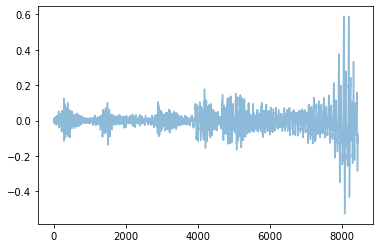

In [150]:
reconstructed_wav = vocoder.inference(batch.melspec_prediction[0:1].transpose(-1, -2)).cpu()

plt.plot(reconstructed_wav.squeeze(), label='reconstructed', alpha=.5)
# plt.grid()
# plt.legend()
plt.show()

In [151]:
display.display(display.Audio(reconstructed_wav, rate=22050))

In [110]:
reconstructed_wav = vocoder.inference(batch.melspec_prediction[0:1].transpose(-1, -2)).cpu()
waveform = vocoder.inference(batch.melspec[0:1]).cpu()

plt.plot(reconstructed_wav.squeeze(), label='reconstructed', alpha=.5)
plt.plot(waveform.squeeze(), label='GT', alpha=.5)
# plt.grid()
# plt.legend()
plt.show()

TypeError: 'NoneType' object is not subscriptable

In [111]:
display.display(display.Audio(reconstructed_wav, rate=22050))
display.display(display.Audio(waveform, rate=22050))

In [75]:
index = 0

waveform = dummy_batch.waveform[index][:dummy_batch.waveforn_length[index]]
durations = dummy_batch.durations[index][:dummy_batch.token_lengths[index]]

# scale by waveform domain
durations = durations * dummy_batch.waveforn_length[index]
durations = durations.cumsum(dim=0).int()

print(dummy_batch.transcript[index])
left = 0
for right, char in zip(durations[:10], dummy_batch.transcript[index]):
    print(char)
    display.display(display.Audio(waveform[left:right], rate=22050))
    left = right
    print('-' * 99)

Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition
P


---------------------------------------------------------------------------------------------------
r


---------------------------------------------------------------------------------------------------
i


---------------------------------------------------------------------------------------------------
n


---------------------------------------------------------------------------------------------------
t


---------------------------------------------------------------------------------------------------
i


---------------------------------------------------------------------------------------------------
n


---------------------------------------------------------------------------------------------------
g


---------------------------------------------------------------------------------------------------
,


---------------------------------------------------------------------------------------------------
 


---------------------------------------------------------------------------------------------------
